In [ ]:
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install morfeusz2
!sudo apt install python3-morfeusz2

# instalacja spaCy
!python3 -m pip install spacy

# 1. instalacja modelu IPI PAN dla języka polskiego
!wget "http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz"
!mv 'SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz' pl_spacy_model_morfeusz-0.1.3.tar.gz
!python3 -m pip install pl_spacy_model_morfeusz-0.1.3.tar.gz

# linkowanie modelu do spaCy
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz -f

# 2. instalacja oficjalnego modelu spaCy
!python3 -m spacy download pl_core_news_lg

# dodatkowe zależności:
!python3 -m pip install tqdm
!python3 -m pip install networkx

In [65]:
import spacy
import requests
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools as fs
import re
import io
import morfeusz2
import plotly.graph_objects as go
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nlp = spacy.load("pl_spacy_model_morfeusz") # IPI PAN

from google.colab import files

Ładowanie plików lokalnie

In [ ]:
uploaded = files.upload()

In [ ]:
def document_decoder(document):
  return uploaded[document].decode("utf-8").replace('\n', ' ').replace('\r',' ')

In [ ]:
def tokenizer(document):
  tokens = nlp(document)
  tokens = [ token.lemma_  for token in tokens if (
      bool(re.search(r'^[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]*[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]$',token.lemma_)) and \
      token.is_stop == False and \
      token.is_punct == False and \
      token.tag_ == 'subst')] 
  return tokens

In [38]:
def svd_implemented(A):
  #centralize features - substract mean

  print ("Input:")
  print (A)
  print ("*****************************")

  U, S, V = np.linalg.svd(A)

  print("Macierz U")
  print(U)

  print("Macierz S")
  print(S)

  print("Macierz V")
  print(V)

  svd = TruncatedSVD(n_components = 3)
  DTM_T = svd.fit_transform(A) 
  V = svd.components_
  Λ = np.zeros([3,3])
  np.fill_diagonal(Λ,svd.singular_values_)
  U = DTM_T.dot(np.linalg.inv(Λ))

  result = U.dot(Λ).dot(V)
  print("Output: ")
  print(result)

  df_A  = pd.DataFrame(data = V, columns =countVectorizer.get_feature_names() , index=['Termin 1','Termin 2','Termin 3'])
  df_U = pd.DataFrame(data=U, columns=['Termin 1','Termin 2','Termin 3'], index = articles.keys())

  return df_A, df_U

# 1. Utworzyć korpus wybranych dokumentów tekstowych (co najmniej 7 dokumentów), pochodzących z 3 różnych działów (np. ekonomia, sport, polityka, motoroyzacja etc.

In [88]:
#SPORT
charakterystyka_rynku_sportu_profesjonalnego = "charakterystyka_rynku_sportu_profesjonalnego.txt"
strategia_rozwoju_sportu_w_polsce = "strategia_rozwoju_sportu_w_polsce.txt"

#MUZYKA
muzyka_w_literaturze = "muzyka_w_literaturze.txt"
zwiazek_miedzy_dzwiekiem_a_krajobrazem = "zwiazek_miedzy_dzwiekiem_a_krajobrazem.txt"

#MOTORYZACJA
motoryzacja_w_polsce = "motoryzacja_w_polsce.txt"
motoryzacja_wplyw_na_swiat ="motoryzacja_wplyw_na_swiat.txt"
samochod_wyzwanie_dla_miasta = "samochod_wyzwanie_dla_miasta.txt"

In [89]:
titles = ["charakterystyka_rynku_sportu_profesjonalnego", "strategia_rozwoju_sportu_w_polsce", "muzyka_w_literaturze", "zwiazek_miedzy_dzwiekiem_a_krajobrazem", 
          "motoryzacja_w_polsce", "motoryzacja_wplyw_na_swiat", "samochod_wyzwanie_dla_miasta"]
#SPORT
charakterystyka_rynku_sportu_profesjonalnego_dec = document_decoder(charakterystyka_rynku_sportu_profesjonalnego)
strategia_rozwoju_sportu_w_polsce_dec = document_decoder(strategia_rozwoju_sportu_w_polsce)

#MUZYKA
muzyka_w_literaturze_dec = document_decoder(muzyka_w_literaturze)
zwiazek_miedzy_dzwiekiem_a_krajobrazem_dec = document_decoder(zwiazek_miedzy_dzwiekiem_a_krajobrazem)

#MOTORYZACJA
motoryzacja_w_polsce_dec = document_decoder(motoryzacja_w_polsce)
motoryzacja_wplyw_na_swiat_dec = document_decoder(motoryzacja_wplyw_na_swiat)
samochod_wyzwanie_dla_miasta_dec = document_decoder(samochod_wyzwanie_dla_miasta)

doc_list =[charakterystyka_rynku_sportu_profesjonalnego_dec, strategia_rozwoju_sportu_w_polsce_dec, 
           muzyka_w_literaturze_dec,zwiazek_miedzy_dzwiekiem_a_krajobrazem_dec,
           motoryzacja_w_polsce_dec,motoryzacja_wplyw_na_swiat_dec,samochod_wyzwanie_dla_miasta_dec]
combined_txt = ' '.join(doc_list)

articles = dict(zip(titles, doc_list))

#2. Zbudować macierz DTM (Document Term Matrix) wykorzystując formy podstawowe słów.

In [91]:
countVectorizer = CountVectorizer(tokenizer=tokenizer, lowercase=False)
countTokenTable = countVectorizer.fit_transform(doc_list)
countTable = pd.DataFrame(data=countTokenTable.toarray(), columns=countVectorizer.get_feature_names())
countTable

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,AC,Adam,Aires,Alfred,Allan,Allen,Ameryka,Amsterdam,Anda,Andrzej,Antonina,Antwerpia,Arystoteles,Atena,Atlanta,Australia,Bachtin,Barańczak,Barbara,Barcelona,Barthes,Bayern,Bean,Becker,Beethoven,Beim,Belgia,Berlin,Bernard,Bernhard,Berno,Białoszewski,Bielsk,Bieroń,Bogusław,Brooke,Brown,Butor,CD,CIA,...,zlecenie,zmiana,zmienność,zmniejszenie,znaczenie,znajomość,znajomy,znak,zniszczenie,zrzeszenie,zróżnicowanie,związek,związka,zwiększenie,zwolennik,zwycięstwo,zwycięzca,zwyczaj,zysk,ćwiczenia,ćwierćwiecze,łada,łam,łut,łyżwiarstwo,Śląsk,Świdnik,ścieżka,śmierć,środek,środowisko,świadczenie,świadomość,świat,światła,światło,źródło,Żerań,żak,życie
0,1,0,0,0,0,0,1,0,0,9,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,6,0,1,0,0,0,1,8,0,0,1,3,1,0,7,0,0,0,3,0,1,0,0,0,0,1,1,1,0,2,0,0,7,0,0,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,6,0,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,2,0,0,17
2,0,0,0,0,0,1,0,3,15,0,0,0,0,0,2,0,4,1,0,0,23,0,0,0,2,0,0,0,1,0,1,1,0,1,3,1,2,13,0,1,...,0,1,0,0,3,1,0,1,0,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0
3,0,1,3,1,1,0,1,0,4,0,1,0,2,0,0,0,0,0,11,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,21,1,0,15,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,0,0,0,0,0,15
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,6,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,2,1,0,1,1,0,0,1,0,0,0,2,0,0,1,1,1,2
5,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,11,0,1,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,1
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,5,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,2,0,1,3,1,0,2,0,0,16


#3. Wyodrębnić koncepty  z wykorzystaniem SVD:

**a) wyznaczyć macierze U, S, V.**



In [92]:
TDM = countTable.to_numpy()
A, U = svd_implemented(TDM)
A

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Input:
[[ 1  0  0 ...  0  0  2]
 [ 0  0  0 ...  0  0 17]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  1  2]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  0 16]]
*****************************
Macierz U
[[-0.12996495  0.91991961  0.1406907  -0.34012332  0.01213762 -0.03094201
  -0.01656939]
 [-0.08576513  0.34215622 -0.06172385  0.916451    0.02590672  0.17487113
   0.0251024 ]
 [-0.02217373  0.02755907 -0.16054167 -0.03634303 -0.96204261  0.21405208
  -0.01760978]
 [-0.0530958   0.09704167 -0.97165043 -0.11470877  0.1738189   0.01555597
   0.00678909]
 [-0.23745827 -0.01754026 -0.00531121  0.023167   -0.08376164 -0.32386304
   0.911503  ]
 [-0.93963588 -0.16165908  0.05720031 -0.06580686  0.06478607  0.23346569
  -0.15698687]
 [-0.18204562  0.00768919 -0.05672763  0.15839042 -0.17952515 -0.87350381
  -0.37849246]]
Macierz S
[332.72470495 255.88613239 172.9177634  124.6362787   99.05412617
  91.3616319   62.98519987]
Macierz V
[[-3.90608057e-04 -1.59578775e-04 -4.78736324e-04 ... -7.13

,AC,Adam,Aires,Alfred,Allan,Allen,Ameryka,Amsterdam,Anda,Andrzej,Antonina,Antwerpia,Arystoteles,Atena,Atlanta,Australia,Bachtin,Barańczak,Barbara,Barcelona,Barthes,Bayern,Bean,Becker,Beethoven,Beim,Belgia,Berlin,Bernard,Bernhard,Berno,Białoszewski,Bielsk,Bieroń,Bogusław,Brooke,Brown,Butor,CD,CIA,...,zlecenie,zmiana,zmienność,zmniejszenie,znaczenie,znajomość,znajomy,znak,zniszczenie,zrzeszenie,zróżnicowanie,związek,związka,zwiększenie,zwolennik,zwycięstwo,zwycięzca,zwyczaj,zysk,ćwiczenia,ćwierćwiecze,łada,łam,łut,łyżwiarstwo,Śląsk,Świdnik,ścieżka,śmierć,środek,środowisko,świadczenie,świadomość,świat,światła,światło,źródło,Żerań,żak,życie
Termin 1,0.000391,0.000160,0.000479,0.000160,0.000160,0.000067,0.001097,0.000200,0.015758,0.003515,0.000160,0.000714,0.000319,0.000258,0.000391,0.000547,0.000267,0.000067,0.001755,0.000648,0.001533,0.000391,0.000547,0.000160,0.000133,0.002736,0.000714,0.000547,0.000067,0.000547,0.000067,0.000067,0.000714,0.000067,0.000914,0.000067,0.000133,0.000866,0.002824,0.000067,...,0.000258,0.044687,0.000160,0.002824,0.008034,0.000780,0.000391,0.000226,0.000714,0.000160,0.003215,0.013738,0.000258,0.003371,0.000457,0.001172,0.000391,0.000160,0.003448,0.000258,0.011296,0.005648,0.005423,0.000714,0.000391,0.000714,0.000714,0.000547,0.000133,0.005192,0.002160,0.000391,0.000707,0.004488,0.000547,0.000067,0.024826,0.000714,0.000714,0.020563
Termin 2,0.003595,0.000379,0.001138,0.000379,0.000379,0.000108,0.004004,0.000323,-0.000026,0.032355,0.000379,-0.000069,0.000758,0.001337,0.001553,0.000030,0.000431,0.000108,0.004172,0.004932,0.002477,0.003595,0.000030,0.000379,0.000215,0.000150,-0.000069,0.000030,0.000108,0.000030,0.000108,0.000108,-0.000069,0.000108,0.000255,0.000108,0.000215,0.001400,-0.000632,0.000108,...,0.001337,0.033989,0.000379,-0.000632,0.034259,0.000039,0.003595,0.000487,-0.000069,0.000379,0.002963,0.027395,0.001337,-0.000602,0.003703,0.010785,0.003595,0.000379,0.025097,0.001337,-0.002527,-0.001264,0.010016,-0.000069,0.003595,-0.000069,-0.000069,0.000030,0.000215,0.005074,0.006709,0.003595,0.000409,0.008660,0.000030,0.000108,0.023409,-0.000069,-0.000069,0.035322
Termin 3,-0.000814,0.005619,0.016857,0.005619,0.005619,0.000928,0.005134,0.002785,0.034749,-0.007323,0.005619,0.000031,0.011238,0.000357,0.002214,0.000328,0.003714,0.000928,0.061811,-0.000457,0.021354,-0.000814,0.000328,0.005619,0.001857,0.001640,0.000031,0.000328,0.000928,0.000328,0.000928,0.000928,0.000031,0.000928,0.002816,0.000928,0.001857,0.012070,-0.000331,0.000928,...,0.000357,0.112907,0.005619,-0.000331,0.084662,0.000959,-0.000814,0.006548,0.000031,0.005619,-0.001144,-0.002172,0.000357,-0.000003,0.000115,-0.002441,-0.000814,0.005619,-0.005665,0.000357,-0.001323,-0.000662,-0.002710,0.000031,-0.000814,0.000031,0.000031,0.000328,0.001857,0.001870,0.006176,-0.000814,0.005947,0.021895,0.000328,0.000928,-0.006610,0.000031,0.000031,0.093708


**b) Przedstawić w postaci chmury tagów słowa należące do każdego tematu (wielkość słowa powinna odpowiadać sile związku słowa z tematem)**



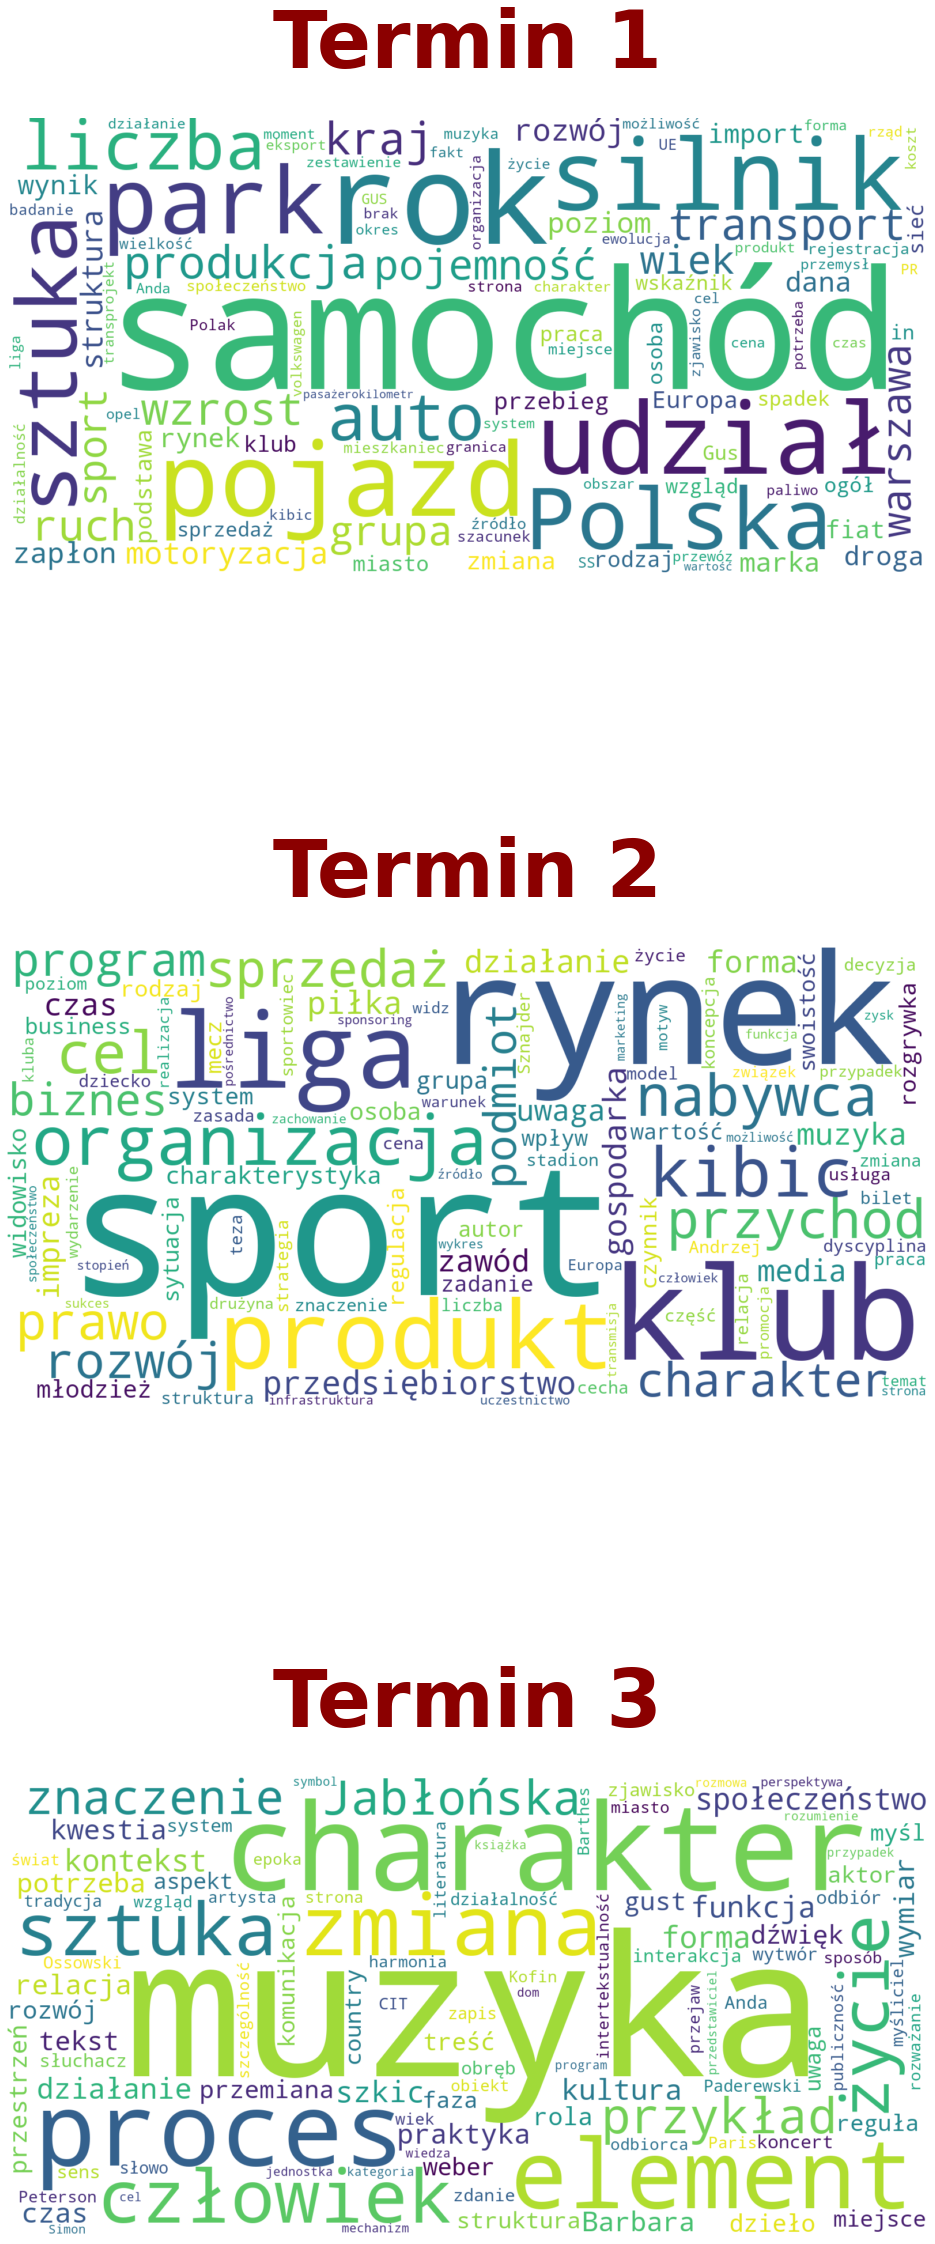

In [101]:
fig = plt.figure(figsize=[100,100])
fig.subplots_adjust(hspace=0.8)

titles = list(A.index)

for i in range(len(titles)):
  word_cloud = WordCloud(width=1600, height=800, collocations = False, background_color = 'white', max_words=100, contour_width=3,
                         contour_color='green').generate_from_frequencies(A.loc[titles[i]])
  
  ax = fig.add_subplot(7,1,i+1)
  ax.imshow( word_cloud,interpolation='bilinear')
  ax.axis('off')
  ax.set_title(titles[i], fontdict={'fontsize':80}, color='darkred',pad=50, fontweight='bold')

plt.show()

In [94]:
U

,Termin 1,Termin 2,Termin 3
charakterystyka_rynku_sportu_profesjonalnego,0.129965,0.919920,-0.140691
strategia_rozwoju_sportu_w_polsce,0.085765,0.342156,0.061724
muzyka_w_literaturze,0.022174,0.027559,0.160542
zwiazek_miedzy_dzwiekiem_a_krajobrazem,0.053096,0.097042,0.971650
motoryzacja_w_polsce,0.237458,-0.017540,0.005311
motoryzacja_wplyw_na_swiat,0.939636,-0.161659,-0.057200
samochod_wyzwanie_dla_miasta,0.182046,0.007689,0.056728


**c) przedstawić w postaci wykresu radarowego tematy każdego z dokumentów**

Przypisałem odpowiednie tematy:
* Motoryzacja
* Sport
* Muzyka

In [102]:
fig = go.Figure()

for title in articles.keys():
  fig.add_trace(go.Scatterpolar(
        r=U.loc[title],
        theta=['Motoryzacja','Sport','Muzyka'],
        fill='toself',
        name=title
        
  ))

fig.show()